## Importing Library

In [7]:
#EDA imports
import pandas as pd
import numpy as np
import sqlite3
import os
import re
import contractions
import nltk
import time
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# ML imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import joblib
#DL Model imports
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModel, BertTokenizerFast, AdamW
from transformers import AutoTokenizer, AutoModel
from BERT_model import BERT_Arch

device = torch.device("cpu")
from warnings import filterwarnings
filterwarnings('ignore')


## Loading Data From SQL Database

In [8]:
# Database file
DB_FILE = r"Database_File\imdb_reviews.db"
DB_TABLE_NAME = "imdb_reviews"
CSV_FILE = r"IMDB Dataset.csv"
BATCH_SIZE = 1000

In [9]:
def read_data(limit):
    if not os.path.isfile(DB_FILE):
        print("Database doesn't Exist")
        exit(0)
    try:
        with sqlite3.connect(DB_FILE) as conn:
            query = f"SELECT * FROM {DB_TABLE_NAME}"
            if limit:
                query += f" LIMIT {limit}"
            IbDM_df = pd.read_sql_query(query, conn)
            print(f"Fetched {len(IbDM_df)} rows from the table '{DB_TABLE_NAME}'.")
            return IbDM_df
    except sqlite3.Error as e:
        print(f"Error reading from database: {e}")
    return None

In [10]:
IbDM_df=read_data(limit=None)

Fetched 50000 rows from the table 'imdb_reviews'.


## Pre-processing Data

In [11]:
IbDM_df.head()


,id,review,sentiment
0,1,One of the other reviewers has mentioned that ...,positive
1,2,A wonderful little production. <br /><br />The...,positive
2,3,I thought this was a wonderful way to spend ti...,positive
3,4,Basically there's a family where a little boy ...,negative
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
IbDM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         50000 non-null  int64 
 1   review     50000 non-null  object
 2   sentiment  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [13]:
num_duplicates = IbDM_df.duplicated().sum()
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 0 duplicate reviews present in the dataset


In [14]:
print('The dataset contains {} rows and {} columns without duplicates'.format(IbDM_df.shape[0],IbDM_df.shape[1]))

The dataset contains 50000 rows and 3 columns without duplicates


In [15]:
IbDM_df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [16]:
def clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: contractions.fix(elem))
    df[new_text_field_name] = df[new_text_field_name].apply(
        lambda elem: re.sub(r"<br\s*/?>\s*(<br\s*/?>)*", " ", elem) #multiple <br > removal
    )
    df[new_text_field_name] = df[new_text_field_name].apply(
        lambda elem: re.sub(r"(@[A-Za-z_]+)|([^A-Za-z0-9\s])|(\w+:\/\/\S+)|^rt|http.+?|<br\s*/?>|^rt[\s]+", " ", elem)
    )
    return df

IbDM_df=clean_text(df=IbDM_df,text_field="review",new_text_field_name="review_clean")
IbDM_df.head()

,id,review,sentiment,review_clean
0,1,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,2,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming te...
2,3,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,4,Basically there's a family where a little boy ...,negative,basically there is a family where a little boy...
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...


#### Remove Stop words

In [17]:
print(IbDM_df["review"][0])
print(IbDM_df["review_clean"][0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [18]:
def content_words(df, text_field, new_text_field_name, stop):
    df[new_text_field_name] = df[text_field].apply(lambda x: ' '.join(
                [word for word in x.split() if word not in (stop)]))
    return df

nltk.download('stopwords')
stop = stopwords.words('english')
specific_sw = ['br', 'movie', 'film']
stop=stop+specific_sw
IbDM_df = content_words(df=IbDM_df,text_field="review_clean", new_text_field_name="review_content_words",stop=stop)
IbDM_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AYUSH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,review,sentiment,review_clean,review_content_words
0,1,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,2,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming te...,wonderful little production filming technique ...
2,3,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,4,Basically there's a family where a little boy ...,negative,basically there is a family where a little boy...,basically family little boy jake thinks zombie...
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,petter mattei love time money visually stunnin...


In [19]:
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
IbDM_df['review_tokens'] = IbDM_df['review_content_words'].apply(lambda x: word_tokenize(x))
IbDM_df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\AYUSH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AYUSH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,review,sentiment,review_clean,review_content_words,review_tokens
0,1,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...,"[one, reviewers, mentioned, watching, 1, oz, e..."
1,2,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming te...,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn..."
2,3,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su..."
3,4,Basically there's a family where a little boy ...,negative,basically there is a family where a little boy...,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,..."
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,petter mattei love time money visually stunnin...,"[petter, mattei, love, time, money, visually, ..."


In [20]:
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
IbDM_df['review_tokens_clean'] = IbDM_df['review_tokens'].apply(lambda x: word_lemmatizer(x))
IbDM_df.head()

,id,review,sentiment,review_clean,review_content_words,review_tokens,review_tokens_clean
0,1,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep..."
1,2,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming te...,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,3,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,4,Basically there's a family where a little boy ...,negative,basically there is a family where a little boy...,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ..."
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,petter mattei love time money visually stunnin...,"[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visually, ..."


#### Dropping intermidiate columns columns

In [21]:
IbDM_df.drop(columns=['review','review_clean','review_content_words','review_tokens'],axis=1,inplace=True)
IbDM_df.head()

,id,sentiment,review_tokens_clean
0,1,positive,"[one, reviewer, mentioned, watching, 1, oz, ep..."
1,2,positive,"[wonderful, little, production, filming, techn..."
2,3,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,4,negative,"[basically, family, little, boy, jake, think, ..."
4,5,positive,"[petter, mattei, love, time, money, visually, ..."


## EDA

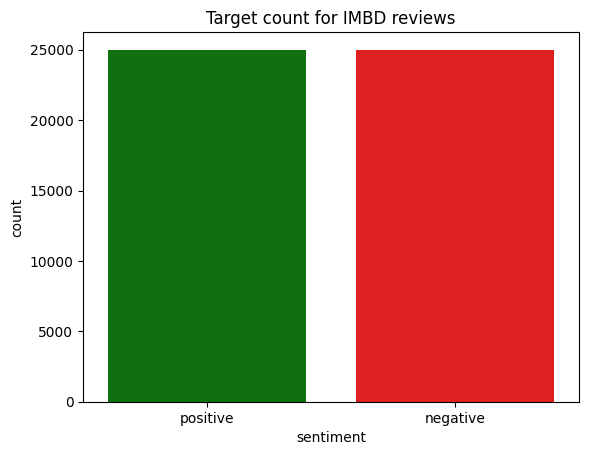

In [22]:
sns.countplot(x='sentiment', data=IbDM_df, palette=['green', 'red'], order=['positive', 'negative'])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Target count for IMBD reviews')
plt.show()

In [23]:
# word cloud on positve reviews
def plot_wordcloud(review, cmap):
    fig, ax = plt.subplots(figsize=(15,15))
    wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white",colormap=cmap)
    wc = wc.generate(review)
    plt.axis('off')
    plt.imshow(wc)

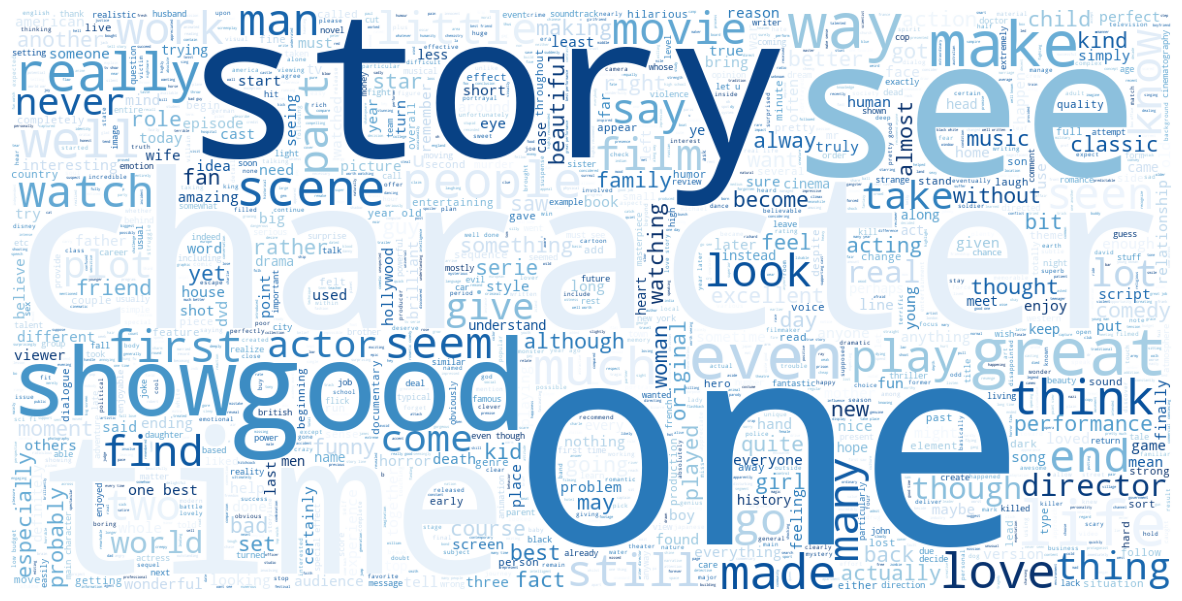

In [24]:
pos_rev_list = IbDM_df[IbDM_df['sentiment'] == 'positive']['review_tokens_clean'].to_list()[:10000]
pos_rev = " ".join([item for sublist in pos_rev_list for item in sublist])

plot_wordcloud(pos_rev, 'Blues')

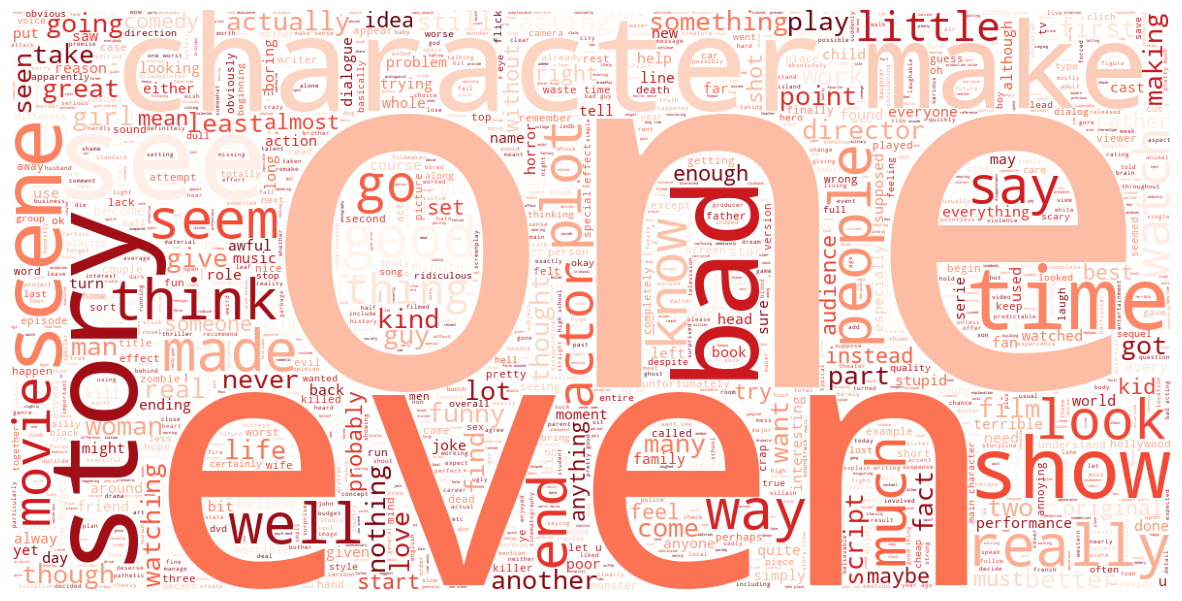

In [25]:
# on negative reviews
neg_rev_list = IbDM_df[IbDM_df['sentiment'] == 'negative']['review_tokens_clean'].to_list()[:10000]
neg_rev = " ".join([item for sublist in neg_rev_list for item in sublist])

plot_wordcloud(neg_rev, 'Reds')

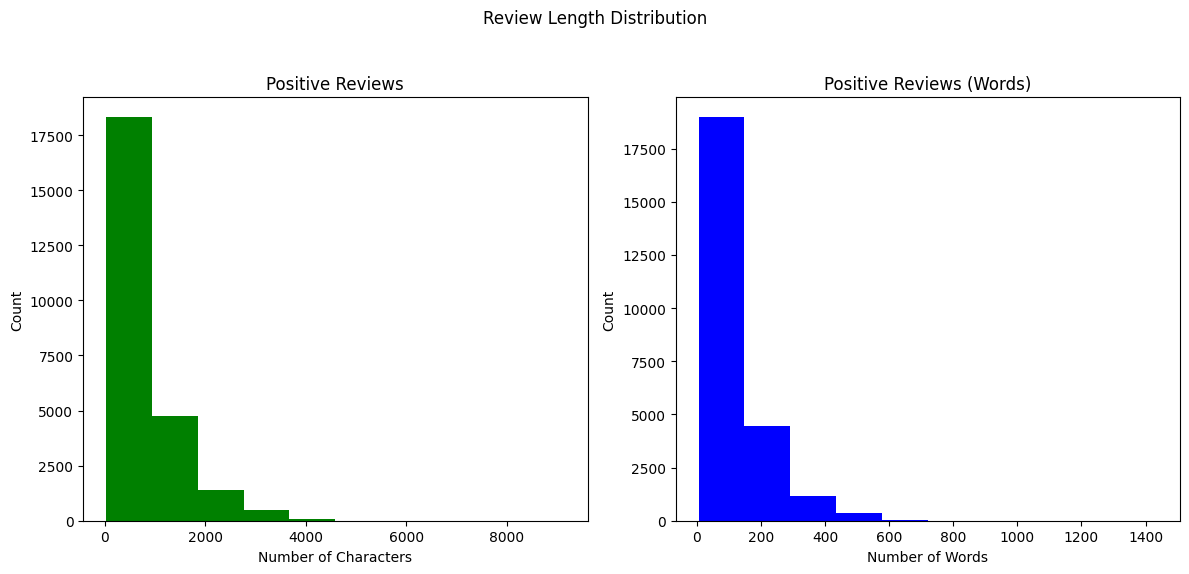

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
negative_data = IbDM_df[IbDM_df['sentiment'] == 'positive']['review_tokens_clean'] 
positive_data_joined = negative_data.apply(lambda x: " ".join(x) if isinstance(x, list) else x)
text_len = positive_data_joined.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')

positive_data_words = IbDM_df[IbDM_df['sentiment'] == 'positive']['review_tokens_clean']
word_counts = positive_data_words.apply(lambda x: len(x) if isinstance(x, list) else 0)
ax2.hist(word_counts, color='blue') 
ax2.set_title('Positive Reviews (Words)')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')

fig.suptitle('Review Length Distribution')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

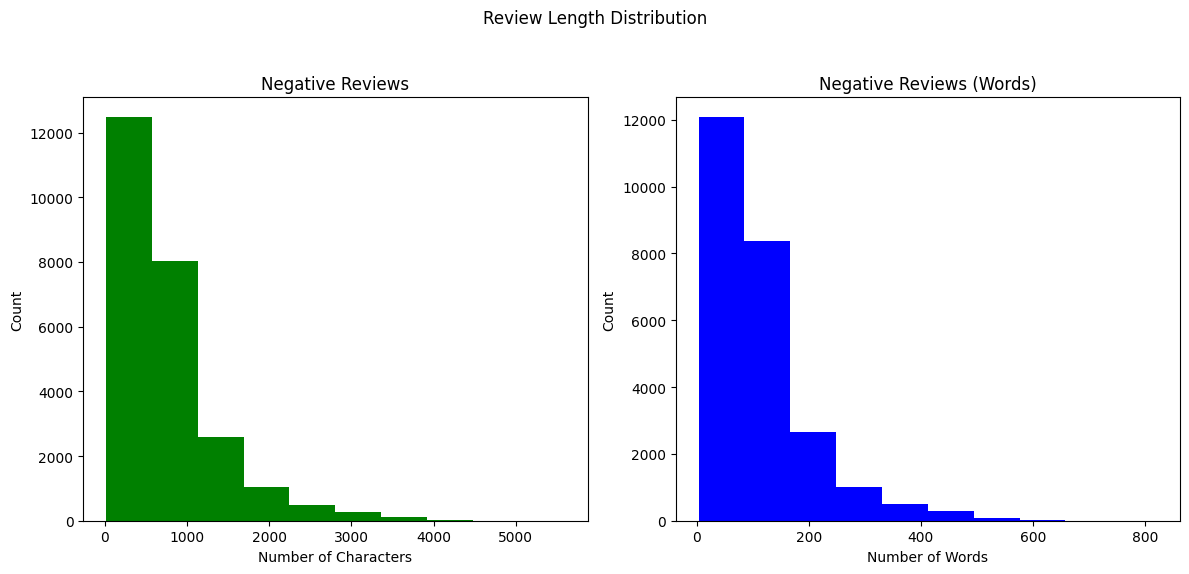

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
negative_data = IbDM_df[IbDM_df['sentiment'] == 'negative']['review_tokens_clean'] 
negative_data_joined = negative_data.apply(lambda x: " ".join(x) if isinstance(x, list) else x)
text_len = negative_data_joined.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Negative Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')

negative_data_words = IbDM_df[IbDM_df['sentiment'] == 'negative']['review_tokens_clean']
word_counts = negative_data_words.apply(lambda x: len(x) if isinstance(x, list) else 0)
ax2.hist(word_counts, color='blue')
ax2.set_title('Negative Reviews (Words)')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')

fig.suptitle('Review Length Distribution') 
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## Predictive Modelling using Machine Learning

In [31]:
#joining the tokens
def join_review_tokens(review_tokens):
    return " ".join(review_tokens)

IbDM_df['review_clean']=IbDM_df['review_tokens_clean'].apply(join_review_tokens)
IbDM_df.drop(columns=['review_tokens_clean'],axis=1,inplace=True)
IbDM_df.head()

KeyError: 'review_tokens_clean'

In [29]:
#splitting into train and test
Xtrain,Xtest,ytrain,ytest= train_test_split(IbDM_df['review_clean'],IbDM_df['sentiment'] ,test_size=0.2, random_state=42)

In [30]:
tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
joblib.dump(tfidf_vect, 'tfidf_vectorizer.joblib')
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

NameError: name 'CountVectorizer' is not defined

In [110]:
IbDM_df['sentiment'] = IbDM_df['sentiment'].replace({'positive': 1, 'negative': 0})

Logistic Regression Accuracy: 89.60%


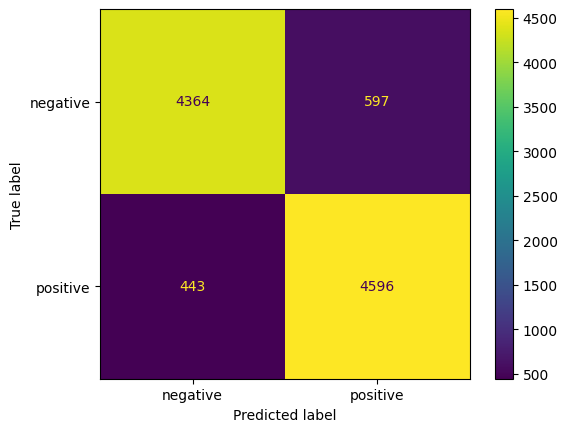

In [111]:
lr = LogisticRegression()
lr.fit(Xtrain_tfidf, ytrain)
y_pred = lr.predict(Xtest_tfidf)

s1 = accuracy_score(ytest, y_pred)
print("Logistic Regression Accuracy:", "{:.2f}%".format(100 * s1))
joblib.dump(lr, 'LogisticRegression_model.joblib')
cm = confusion_matrix(ytest, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(include_values=True, cmap='viridis', ax=None)
plt.grid(False)
plt.show()

Multinomial Naive Bayes Classifier Accuracy : 86.64%


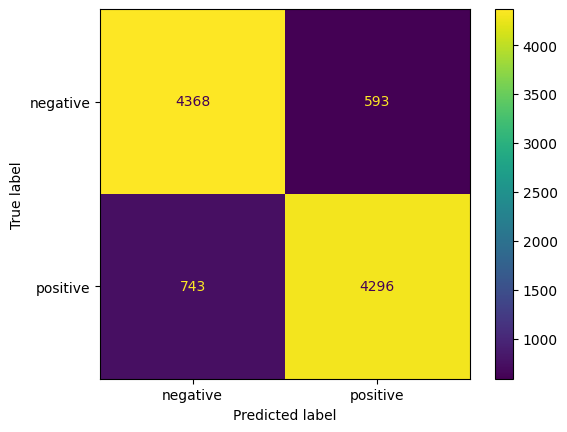

In [112]:
mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
y_pred = mnb.predict(Xtest_tfidf)

s2=accuracy_score(ytest, y_pred)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))
joblib.dump(mnb, 'MultinomialNB_model.joblib')
cm = confusion_matrix(ytest, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb.classes_)
disp.plot(include_values=True, cmap='viridis', ax=None)
plt.grid(False)
plt.show()

Linear SVM Accuracy : 89.87%


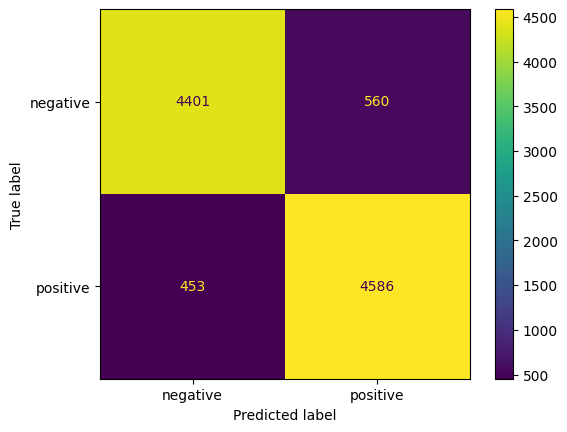

In [113]:
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)
y_pred = linear_svc.predict(Xtest_tfidf)

s3=accuracy_score(ytest, y_pred)
print("Linear SVM Accuracy :", "{:.2f}%".format(100*s3))
joblib.dump(linear_svc, 'linear_svc_model.joblib')
cm = confusion_matrix(ytest, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear_svc.classes_)
disp.plot(include_values=True, cmap='viridis', ax=None)
plt.grid(False)
plt.show()

#### As the best ML model to perform is `LinearSVC` on this particular Task

In [171]:
## Example - Testing the saved model
loaded_tfidf = joblib.load('tfidf_vectorizer.joblib')
loaded_model = joblib.load('linear_svc_model.joblib')

X_t = "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side"
new_text_tfidf = loaded_tfidf.transform([X_t])
predictions = loaded_model.predict(new_text_tfidf)
print("Predictions:", predictions)

Predictions: ['positive']


## Predictive Modelling using Deep Learning

In [32]:
df=IbDM_df.copy(deep=True)
df.head()

,id,sentiment,review_clean
0,1,positive,one reviewer mentioned watching 1 oz episode h...
1,2,positive,wonderful little production filming technique ...
2,3,positive,thought wonderful way spend time hot summer we...
3,4,negative,basically family little boy jake think zombie ...
4,5,positive,petter mattei love time money visually stunnin...


In [33]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_clean'], df['sentiment'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [34]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

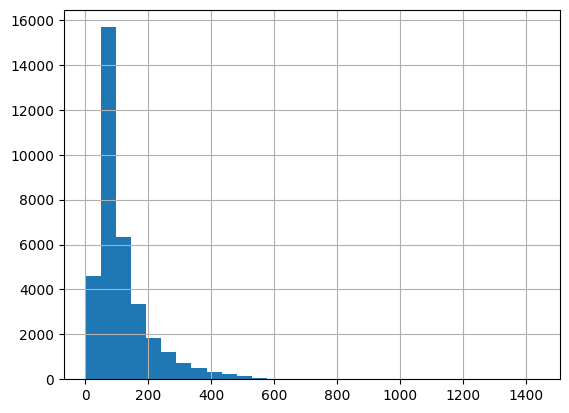

In [35]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [36]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [144]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [145]:
# freeze parameters
for param in bert.parameters():
    param.requires_grad = False

In [147]:
model = BERT_Arch(bert)

In [148]:
# optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

In [149]:
#compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print("Class Weights:",class_weights)

Class Weights: [1. 1.]


In [150]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights)
epochs = 10

In [151]:
# train
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]
    for step,batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss
    avg_loss = total_loss / len(train_dataloader)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [152]:
def format_time(seconds):
    """Format seconds into a string like 'hh:mm:ss'."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [153]:
# evaluating
def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    t0 = time.time()
    for step,batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    avg_loss = total_loss / len(val_dataloader)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [155]:
best_valid_loss = float('inf')
epochs = 10
train_losses=[]
valid_losses=[]
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 1
  Batch    50  of  1,094.
  Batch   100  of  1,094.
  Batch   150  of  1,094.
  Batch   200  of  1,094.
  Batch   250  of  1,094.
  Batch   300  of  1,094.
  Batch   350  of  1,094.
  Batch   400  of  1,094.
  Batch   450  of  1,094.
  Batch   500  of  1,094.
  Batch   550  of  1,094.
  Batch   600  of  1,094.
  Batch   650  of  1,094.
  Batch   700  of  1,094.
  Batch   750  of  1,094.
  Batch   800  of  1,094.
  Batch   850  of  1,094.
  Batch   900  of  1,094.
  Batch   950  of  1,094.
  Batch 1,000  of  1,094.
  Batch 1,050  of  1,094.

Evaluating...
  Batch    50  of    235.
  Batch   100  of    235.
  Batch   150  of    235.
  Batch   200  of    235.

Training Loss: 0.682
Validation Loss: 0.669


In [163]:
model_path = 'saved_weights.pt'
map_location = torch.device('cpu')
model.load_state_dict(torch.load(model_path, map_location=map_location))

<All keys matched successfully>

In [166]:
model.to(device)

test_seq = test_seq.to(device)
test_mask = test_mask.to(device)

with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.cpu().numpy() 

preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

           0       0.61      0.71      0.66      3750
           1       0.65      0.55      0.60      3750

    accuracy                           0.63      7500
   macro avg       0.63      0.63      0.63      7500
weighted avg       0.63      0.63      0.63      7500



In [43]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text, max_length=128):
    """Tokenizes and converts text to tensors."""
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return encoding["input_ids"], encoding["attention_mask"]

def predict_text(text, model):
    """Preprocesses input text, runs model inference, and prediction."""
    input_ids, attention_mask = preprocess_text(text)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        return preds[0]
# Example Usage
device = torch.device("cpu")
text_input = "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked.They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side"
bert = AutoModel.from_pretrained('bert-base-uncased')
model = BERT_Arch(bert)
model.load_state_dict(torch.load('saved_weights.pt', map_location=torch.device('cpu')))
model.to(device)
prediction = predict_text(text_input, model)
print(f"Predicted Class: {prediction}")


Predicted Class: 1
